In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)



In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")


fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [33]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [70]:
cantPalabrasTotales = sum(df.cantPalabra)
df['cantPalabrasTotales'] = cantPalabrasTotales

In [108]:
df.cantPalabra.apply(math.log,args=(2,)).head()

palabra
logroño      11.339850
breñas       11.338736
chivilcoy    11.992230
oberá        12.077483
ush          11.061371
Name: cantPalabra, dtype: float64

In [7]:
df.entropy.describe()

count    75878.000000
mean         2.842564
std          0.409441
min          0.000000
25%          2.796571
50%          2.959232
75%          3.059217
max          3.135044
Name: entropy, dtype: float64

## Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**, **el**,etc. dejan de tener tanto valor de información

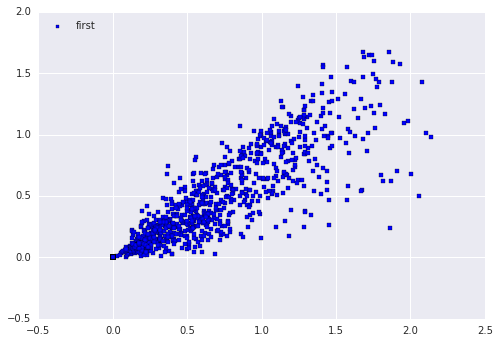

In [106]:
import matplotlib.pyplot as plt

x = resumed.entropy_personas[:1000]
y = resumed.entropy_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

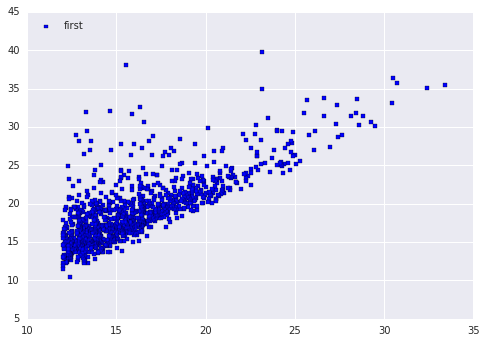

In [107]:
import seaborn
import matplotlib.pyplot as plt

x = resumed.information_value_personas[:1000]
y = resumed.information_value_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [35]:
import math
df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_palabras", ascending=False, inplace=True)

palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras.csv')
resumed.iloc[:1000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax']]

,cantPalabra,cantUsuariosTotal,provinciaFnormMax
palabra,,,
ushuaia,14966,1006,tierradelfuego
rioja,22489,1573,larioja
oberá,4322,378,misiones
chivilcoy,4074,469,buenosaires
logroño,2592,132,larioja
breñas,2590,170,chaco
viedma,6584,666,rionegro
tdf,2716,300,tierradelfuego
bragado,2805,294,buenosaires


## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [36]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

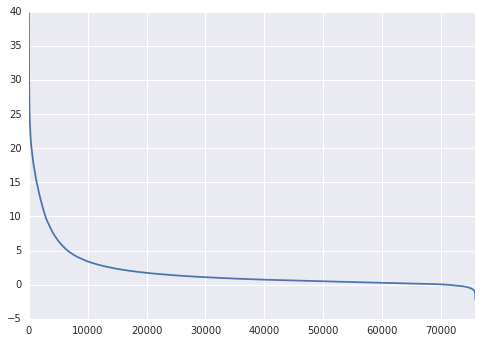

In [44]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
df2 = df.reset_index()
df2.information_value_palabras.plot.line()

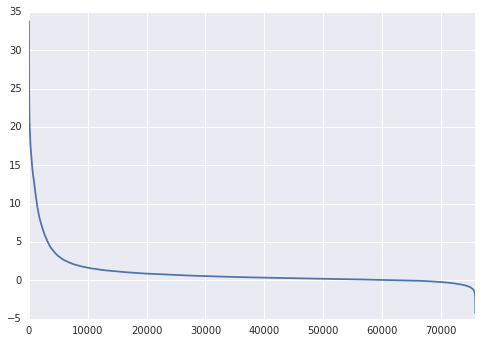

In [46]:
df.sort_values(by="information_value_personas", ascending=False, inplace=True)
df2 = df.reset_index()

df2.information_value_personas.plot.line()

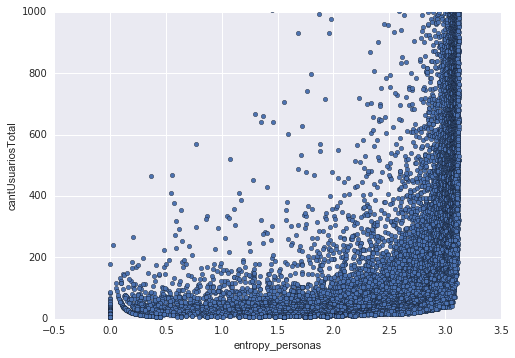

In [83]:
import seaborn
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

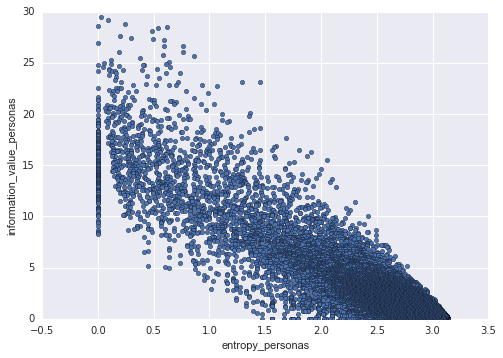

In [87]:
import seaborn
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

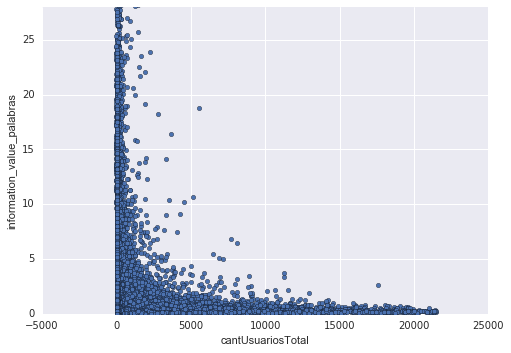

In [90]:
import seaborn
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

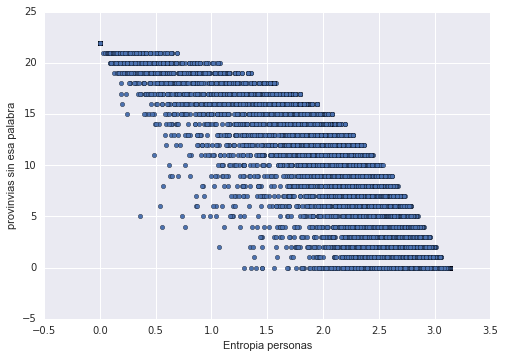

In [96]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


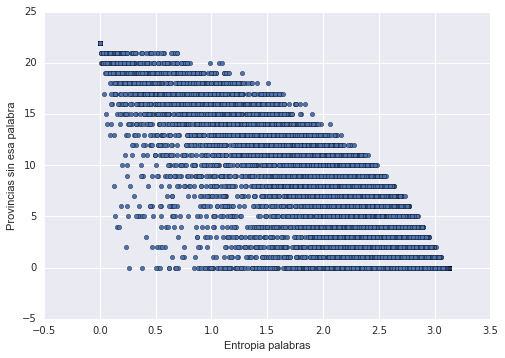

In [101]:

plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

In [11]:
df.plot.scatter?


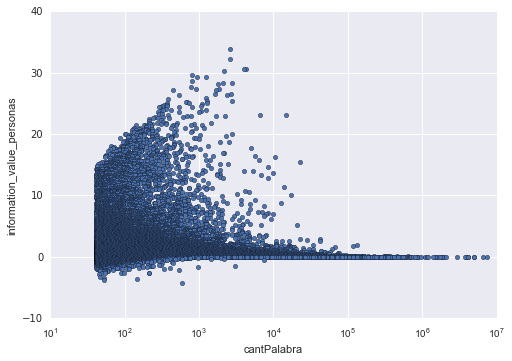

In [12]:
import seaborn
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

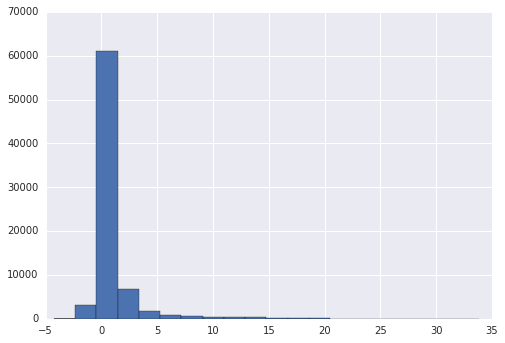

In [13]:
df.information_value_personas.hist(bins=20)

In [105]:
resumed[df.information_value_personas < 0].iloc[:100]

,FnormMax,FnormMin,cantPalabra,cantPalabrasTotales,cantUsuariosTotal,entropy_palabras,entropy_personas,information_value_palabras,information_value_personas,maxDif,provinciaFnormMax,provinciaFnormMin,provinciaSinEsaPalabra,shuffled_entropy_palabras,shuffled_entropy_personas
palabra,,,,,,,,,,,,,,,
palladium,3.714232,0.106356,42,188487018,6,0.798814,1.791759,11.461336,-1.197335e-15,34.922687,chubut,mendoza,17,2.924307,1.791759
ostin,4.628014,0.100082,46,188487018,7,0.692441,1.945910,11.984623,-1.226477e-15,46.242338,corrientes,rionegro,16,2.862169,1.945910
hhttp,3.264022,0.105675,47,188487018,6,0.986352,1.791759,10.179812,-1.233366e-15,30.887391,chubut,entrerios,17,2.819037,1.791759
menzi,6.955464,0.099246,58,188487018,7,0.705645,1.747868,13.009051,-1.300733e-15,70.082787,larioja,cordoba,17,2.926384,1.747868
beny,6.126468,0.105675,60,188487018,8,0.655149,1.667462,13.624852,-1.311593e-15,57.974683,catamarca,entrerios,17,2.961752,1.667462
fsf,6.431719,0.108242,65,188487018,8,0.586287,1.906155,14.360323,-1.337234e-15,59.419600,santafe,tucuman,16,2.970785,1.906155
nxt,8.972598,0.108242,82,188487018,9,0.806161,1.889159,13.595365,-1.411660e-15,82.893581,santiago,tucuman,16,2.944621,1.889159
ako,29.840798,0.105675,259,188487018,8,0.209155,1.906155,23.138234,-1.780089e-15,282.383055,sanjuan,entrerios,16,3.095370,1.906155
encarcelado,0.716179,0.099246,42,188487018,39,2.726265,2.765504,0.014666,-2.394670e-15,7.216172,sanjuan,cordoba,4,2.728985,2.765504
